Train accuracy ~0.34 → 0.38 but flat

Val accuracy stuck exactly at 0.4539

Loss not improving

This means → The model is not learning anything useful

This usually happens when augmentation is too strong + backbone is frozen + small dataset.

In [ ]:
# 1. Mount Drive (run cell)
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory
DATA_DIR = '/content/drive/MyDrive/datasets'  # <- your folder

# 2. Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# 3. Basic params
IMG_SIZE = (224, 224)        # MobileNetV2 typical input
BATCH_SIZE = 16
SEED = 123
EPOCHS_HEAD = 20             # train head
EPOCHS_FINE = 10             # optional fine-tune
VALIDATION_SPLIT = 0.2

# 4. Create tf.data datasets from directory (stratified by subfolders)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

class_names = train_ds.class_names
print("Classes:", class_names)

# 5. Show class distribution (quick)
def dataset_class_counts(dataset):
    counts = {c:0 for c in class_names}
    for images, labels in dataset.unbatch():
        counts[class_names[int(labels.numpy())]] += 1
    return counts

print("Train counts:", dataset_class_counts(train_ds))
print("Val counts:", dataset_class_counts(val_ds))

# 6. Performance - prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# 7. Heavy augmentation (user choice). Put these layers into the model so augmentation is only applied during training.
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.25),   # up to 90 degrees total (0.25*2π? actually radians not used; it's fraction of 2π)
    layers.RandomZoom(0.25),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomContrast(0.2),
    # You can add Gaussian noise if desired:
    layers.Rescaling(1./255),               # will later be countered by preprocess_input; ordering matters (we will preprocess_input after)
], name='heavy_augmentation')

# Note:
# We include Rescaling here because some augmentation layers expect float inputs in [0,1].
# But MobileNet's preprocess_input expects inputs scaled in a certain way. We'll still call preprocess_input later.

# 8. Build model
num_classes = len(class_names)

# Backbone
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet',
                         pooling='avg')

base_model.trainable = False  # freeze for initial training

# Input layer
inputs = keras.Input(shape=(*IMG_SIZE, 3))
# Augmentation (applied only during training)
x = layers.Rescaling(1./255)(inputs)   # ensure float [0,1] for augmentation
x = data_augmentation(x)
# MobileNetV2 expects images preprocessed with preprocess_input. Because we've rescaled to [0,1],
# we need to bring them to the same scale MobileNet expects:
x = preprocess_input(x * 255.0)  # revert to [0,255] then apply mobilenet preprocess
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

# 9. Compile
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 10. Callbacks
checkpoint_path = '/content/drive/MyDrive/mushroom_mobilenetv2_best.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 11. Train head
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks
)

# 12. Optional: fine-tune some top layers of the backbone
# WARNING: Only do this if you have enough images (we will fine-tune carefully for a small dataset).
# Unfreeze top layers of the base model:
fine_tune_at = len(base_model.layers) - 30  # unfreeze last 30 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# compile with lower lr
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD + EPOCHS_FINE,
    initial_epoch=history_head.epoch[-1] + 1 if history_head.epoch else 0,
    callbacks=callbacks
)

# After training, the best weights are saved at checkpoint_path (also restored by EarlyStopping restore_best_weights=True)
print("Best model saved to:", checkpoint_path)

# 13. Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}")

# 14. Predictions + confusion matrix
# Build arrays of true labels and predicted labels
y_true = []
y_pred = []
for images, labels in val_ds.unbatch():
    images = tf.expand_dims(images, 0)  # add batch dimension
    # preprocess same as model input pipeline:
    img = tf.cast(images, tf.float32)
    img = img / 255.0
    img = preprocess_input(img * 255.0)
    preds = model.predict(img, verbose=0)
    y_true.append(int(labels.numpy()))
    y_pred.append(int(np.argmax(preds, axis=-1)[0]))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 15. Plot confusion matrix (nice visualization)
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)

# 16. Visualize augmented images (optional) - see what heavy augmentation produces
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        # apply the augmentation pipeline directly to a single image
        img = images[i]
        img_aug = data_augmentation(tf.expand_dims(img/255.0, 0))
        # convert to uint8 for display
        display_img = tf.cast(tf.clip_by_value(img_aug[0]*255.0, 0, 255), tf.uint8).numpy()
        plt.imshow(display_img)
        plt.axis('off')
plt.suptitle('Examples of heavy augmentation')
plt.show()


Mounted at /content/drive
Found 761 files belonging to 3 classes.
Using 609 files for training.
Found 761 files belonging to 3 classes.
Using 152 files for validation.
Classes: ['Healthy', 'Mixed_Infected', 'Single_Infected']
Train counts: {'Healthy': 240, 'Mixed_Infected': 246, 'Single_Infected': 123}
Val counts: {'Healthy': 59, 'Mixed_Infected': 69, 'Single_Infected': 24}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ heavy_augmentation (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3449 - loss: 1.4346
Epoch 1: val_accuracy improved from -inf to 0.45395, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3452 - loss: 1.4336 - val_accuracy: 0.4539 - val_loss: 1.0200 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3384 - loss: 1.3125
Epoch 2: val_accuracy did not improve from 0.45395
39/39 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3393 - loss: 1.3117 - val_accuracy: 0.4539 - val_loss: 1.0254 - learning_rate: 1.0000e-04
Epoch 3/20
38/39 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3716 - loss: 1.2620
Epoch 3: val_accuracy did not improve from 0.45395
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3724 - loss: 1.2610 - val_accuracy: 0.4539 - val_loss: 1.0173 - learning_rate: 1.0000e-04
Epoch 4/20
38/39 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3697 - loss: 1.2395
Epoch 4: val_accuracy did not improve from 0.45395
39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3684 - loss: 1.2401 - val_accuracy: 0.4539 - val_loss: 1.0190 - learning_rate: 1.0000e-04
Epoch 5/20
38/39 ━━━━━━━━━

KeyboardInterrupt: 

Found 761 files belonging to 3 classes.
Using 609 files for training.
Found 761 files belonging to 3 classes.
Using 152 files for validation.
Classes: ['Healthy', 'Mixed_Infected', 'Single_Infected']
Train counts: {'Healthy': 240, 'Mixed_Infected': 246, 'Single_Infected': 123}
Val counts: {'Healthy': 59, 'Mixed_Infected': 69, 'Single_Infected': 24}
Class weights: {0: np.float64(0.8458333333333333), 1: np.float64(0.8252032520325203), 2: np.float64(1.6504065040650406)}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ light_augmentation (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 2,552,579 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3790 - loss: 1.3233
Epoch 1: val_accuracy improved from -inf to 0.55921, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.3806 - loss: 1.3193 - val_accuracy: 0.5592 - val_loss: 0.9924 - learning_rate: 5.0000e-05
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5307 - loss: 0.9263
Epoch 2: val_accuracy improved from 0.55921 to 0.57237, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5315 - loss: 0.9253 - val_accuracy: 0.5724 - val_loss: 0.9766 - learning_rate: 5.0000e-05
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6061 - loss: 0.7102
Epoch 3: val_accuracy improved from 0.57237 to 0.59211, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6068 - loss: 0.7103 - val_accuracy: 0.5921 - val_loss: 0.9411 - learning_rate: 5.0000e-05
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5816 - loss: 0.8397
Epoch 4: val_accuracy improved from 0.59211 to 0.61842, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5834 - loss: 0.8360 - val_accuracy: 0.6184 - val_loss: 0.9295 - learning_rate: 5.0000e-05
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6865 - loss: 0.5994
Epoch 5: val_accuracy improved from 0.61842 to 0.65132, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6871 - loss: 0.5989 - val_accuracy: 0.6513 - val_loss: 0.8548 - learning_rate: 5.0000e-05
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7009 - loss: 0.5916
Epoch 6: val_accuracy did not improve from 0.65132
39/39 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7017 - loss: 0.5905 - val_accuracy: 0.6513 - val_loss: 0.7920 - learning_rate: 5.0000e-05
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7207 - loss: 0.5240
Epoch 7: val_accuracy did not improve from 0.65132
39/39 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7211 - loss: 0.5239 - val_accuracy: 0.6447 - val_loss: 0.8206 - learning_rate: 5.0000e-05
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7288 - loss: 0.5242
Epoch 8: val_accuracy did not improve from 0.65132
39/39 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7294 - loss: 0.5230 - val_accuracy: 0.6118 - val_loss: 0.8823 - learning_rate: 5.0000e-05
Epoch 9/20
39/39 ━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8064 - loss: 0.4015 - val_accuracy: 0.6579 - val_loss: 0.7918 - learning_rate: 2.5000e-05
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8188 - loss: 0.3852
Epoch 12: val_accuracy improved from 0.65789 to 0.67105, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8190 - loss: 0.3851 - val_accuracy: 0.6711 - val_loss: 0.7485 - learning_rate: 2.5000e-05
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7652 - loss: 0.4212
Epoch 13: val_accuracy did not improve from 0.67105
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7657 - loss: 0.4208 - val_accuracy: 0.6645 - val_loss: 0.7951 - learning_rate: 2.5000e-05
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8194 - loss: 0.3732
Epoch 14: val_accuracy did not improve from 0.67105
39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8195 - loss: 0.3730 - val_accuracy: 0.6447 - val_loss: 0.8263 - learning_rate: 2.5000e-05
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7767 - loss: 0.4341
Epoch 15: val_accuracy improved from 0.67105 to 0.68421, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7771 - loss: 0.4338 - val_accuracy: 0.6842 - val_loss: 0.7681 - learning_rate: 2.5000e-05
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8575 - loss: 0.3068
Epoch 16: val_accuracy improved from 0.68421 to 0.69079, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8571 - loss: 0.3078 - val_accuracy: 0.6908 - val_loss: 0.7482 - learning_rate: 1.2500e-05
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8222 - loss: 0.3616
Epoch 17: val_accuracy improved from 0.69079 to 0.70395, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8221 - loss: 0.3618 - val_accuracy: 0.7039 - val_loss: 0.7342 - learning_rate: 1.2500e-05
Epoch 18/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8111 - loss: 0.3741
Epoch 18: val_accuracy improved from 0.70395 to 0.73026, saving model to /content/drive/MyDrive/mushroom_mobilenetv2_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8112 - loss: 0.3737 - val_accuracy: 0.7303 - val_loss: 0.6885 - learning_rate: 1.2500e-05
Epoch 19/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8220 - loss: 0.3595
Epoch 19: val_accuracy did not improve from 0.73026
39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8220 - loss: 0.3597 - val_accuracy: 0.7039 - val_loss: 0.7063 - learning_rate: 1.2500e-05
Epoch 20/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8147 - loss: 0.3500
Epoch 20: val_accuracy did not improve from 0.73026
39/39 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8149 - loss: 0.3501 - val_accuracy: 0.7303 - val_loss: 0.6848 - learning_rate: 1.2500e-05
Restoring model weights from the end of the best epoch: 20.
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7489 - loss: 0.6907
Validation loss: 0.6848, val accuracy: 0.7303
Confusion matrix:
 [[ 0 59  0]
 [ 0 69  0]
 [ 0 24  0]]

Classification report:
                 precision    recall  f1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


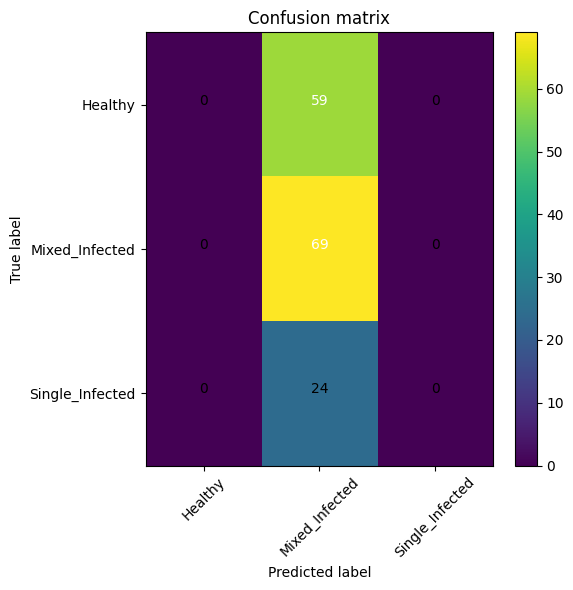

In [ ]:
# 1. Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path
DATA_DIR = '/content/drive/MyDrive/datasets'  # <- adjust if needed

# 2. Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 3. Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 123
EPOCHS = 20
VALIDATION_SPLIT = 0.2

# 4. Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

class_names = train_ds.class_names
print("Classes:", class_names)

# 5. Check class distribution
def dataset_class_counts(dataset):
    counts = {c:0 for c in class_names}
    for _, labels in dataset.unbatch():
        counts[class_names[int(labels.numpy())]] += 1
    return counts

print("Train counts:", dataset_class_counts(train_ds))
print("Val counts:", dataset_class_counts(val_ds))

# 6. Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# 7. Lighter data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="light_augmentation")

# 8. Compute class weights
labels_list = []
for _, labels in train_ds.unbatch():
    labels_list.append(int(labels.numpy()))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_list),
    y=labels_list
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# 9. Build model
num_classes = len(class_names)
base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Input + augmentation
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = preprocess_input(x * 255.0)  # scale back to MobileNet input
x = base_model(x, training=True)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

# 10. Compile
optimizer = keras.optimizers.Adam(learning_rate=5e-5)  # fine-tuning learning rate
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 11. Callbacks
checkpoint_path = '/content/drive/MyDrive/mushroom_mobilenetv2_best.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 12. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# 13. Evaluate
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}")

# 14. Predictions + confusion matrix
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    img = tf.expand_dims(tf.cast(images, tf.float32)/255.0, 0)
    img = preprocess_input(img * 255.0)
    preds = model.predict(img, verbose=0)
    y_true.append(int(labels.numpy()))
    y_pred.append(int(np.argmax(preds, axis=-1)[0]))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 15. Confusion matrix plot
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)


MobileNetV2 backbone

Lighter data augmentation

Last 20 layers of MobileNetV2 unfrozen

Class weights to handle imbalance

Train + validation split from your Drive dataset